<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/Conditional%20GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import models & layers from TF/keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# tensor manipulation library
import numpy as np
# plotting library
import matplotlib.pyplot as plt
!pip install plot_model
from plot_model import plot_model
# disabling eager (slower) execution
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

In [215]:
# dataset download
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat

# reading configurations and temperatures into numpy 
# (10k elements with 28x28 spin configuration)
conf, label = np.loadtxt('ising2_conf.dat'), np.loadtxt('ising2_label.dat')

--2020-06-02 15:02:50--  http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.1, 141.108.26.150
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19060775 (18M)
Saving to: ‘ising2_conf.dat.1’

ising2_conf.dat.1   100%[===================>]  18.18M  7.27MB/s    in 2.5s    

2020-06-02 15:02:52 (7.27 MB/s) - ‘ising2_conf.dat.1’ saved [19060775/19060775]

--2020-06-02 15:02:54--  http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.1, 141.108.26.150
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81025 (79K)
Saving to: ‘ising2_label.dat.1’

ising2_label.dat.1  100%[===================>]  79.13K  --.-KB/s    in 0.06s   

2020-06-02 15:02:54 (1.39 MB/s) - ‘ising2_label.dat.1’ saved [81

In [0]:
BATCH_SIZE = 64
IMG_SHAPE = (28, 28, 1)
NUM_TEMP_CLASSES = 6
EMBEDDING_DIM = 64
LATENT_DIM = 128

In [0]:
# reshaping configurations into matrix form and specifying dtype
conf = conf.reshape(-1, *IMG_SHAPE).astype('float32')
temp = label.reshape(-1, 1).round()

one_hot_temp = keras.utils.to_categorical(temp.astype("int32"))
# converting data (conf and temperatures) into tensorflow Dataset
dataset = tf.data.Dataset.from_tensor_slices((conf, one_hot_temp))
# shuffling and prefetching
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(32)

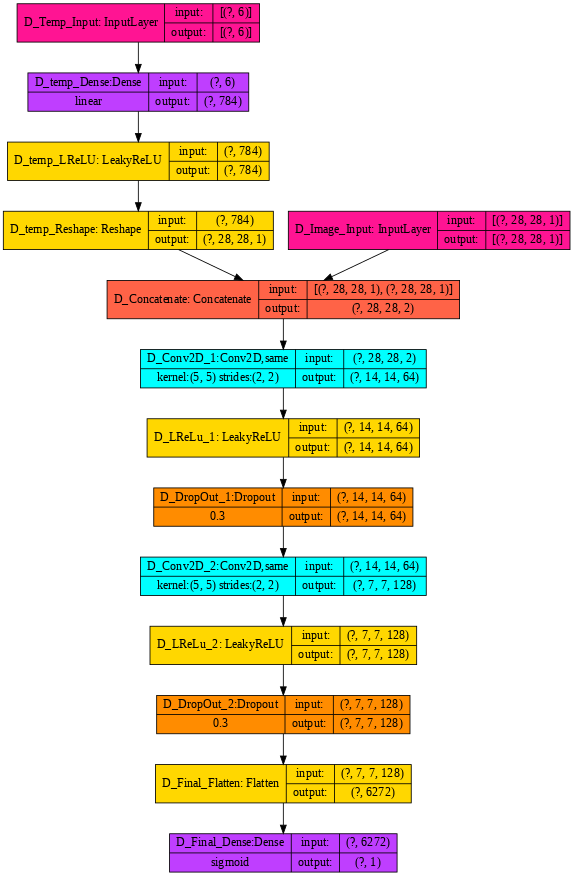

In [311]:
def get_discriminator_model():

    img_input = layers.Input(shape=IMG_SHAPE, name="D_Image_Input")
    temp_input = layers.Input(shape=(NUM_TEMP_CLASSES,), name="D_Temp_Input")

    t = layers.Dense(28*28, name="D_temp_Dense")(temp_input)
    t = layers.LeakyReLU(name="D_temp_LReLU")(t)
    t = layers.Reshape(IMG_SHAPE, name="D_temp_Reshape")(t)

    x = layers.Concatenate(name="D_Concatenate")([t, img_input])

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', 
                      input_shape=IMG_SHAPE, name="D_Conv2D_1")(x)
    x = layers.LeakyReLU(name="D_LReLu_1")(x)
    x = layers.Dropout(0.3, name="D_DropOut_1")(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), 
                      padding='same', name="D_Conv2D_2")(x)
    x = layers.LeakyReLU(name="D_LReLu_2")(x)
    x = layers.Dropout(0.3, name="D_DropOut_2")(x)

    x = layers.Flatten(name="D_Final_Flatten")(x)
    x = layers.Dense(1, name="D_Final_Dense", activation="sigmoid")(x)

    model = keras.models.Model([img_input, temp_input], x, name="discriminator")
    return model

d_model = get_discriminator_model()
plot_model(d_model, 
  dpi=60, color=True, style=1, to_file="d_model.png", show_layer_names=True)

4026672


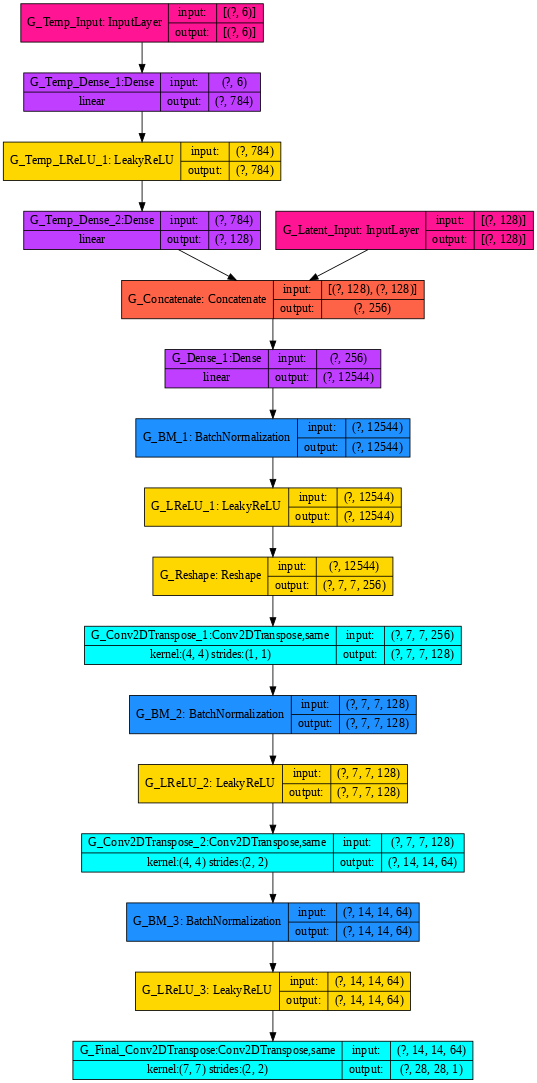

In [310]:
def get_generator_model():

    temp_input = layers.Input(shape=(NUM_TEMP_CLASSES,), name="G_Temp_Input")

    t = layers.Dense(28*28, name="G_Temp_Dense_1")(temp_input)
    t = layers.LeakyReLU(name="G_Temp_LReLU_1")(t)

    t = layers.Dense(LATENT_DIM, name="G_Temp_Dense_2")(t)

    latent_vector = layers.Input(shape=(LATENT_DIM,), name="G_Latent_Input")

    x = layers.Concatenate(name="G_Concatenate")([latent_vector, t])

    x = layers.Dense(7*7*256, use_bias=False, 
                     input_shape=(2*LATENT_DIM,), name="G_Dense_1")(x)
    x = layers.BatchNormalization(name="G_BM_1")(x)
    x = layers.LeakyReLU(name="G_LReLU_1")(x)

    x = layers.Reshape((7, 7, 256), name="G_Reshape")(x)
    
    x = layers.Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same', 
                               use_bias=False, name="G_Conv2DTranspose_1")(x)
    x = layers.BatchNormalization(name="G_BM_2")(x)
    x = layers.LeakyReLU(name="G_LReLU_2")(x)

    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', 
                               use_bias=False, name="G_Conv2DTranspose_2")(x)
    x = layers.BatchNormalization(name="G_BM_3")(x)
    x = layers.LeakyReLU(name="G_LReLU_3")(x)

    x = layers.Conv2DTranspose(1, (7, 7), strides=(2, 2), padding='same',
       use_bias=False, activation=tf.tanh, name="G_Final_Conv2DTranspose")(x)

    model = keras.models.Model([temp_input, latent_vector], x, name="generator")
    return model

g_model = get_generator_model()
print(g_model.count_params())
plot_model(g_model, 
  dpi=60, color=True, style=1, to_file="g_model.png", show_layer_names=True)

In [0]:
# Modello DCGAN: implementiamo un keras.Model custom
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    # funzione per la compilazione
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, train_batch):
        if isinstance(train_batch, tuple): #verifica che l'input isa una python tuple (numpy tensor)
            real_images, temp = train_batch

        # 1) campiona un batch di punti random nello spazio latente: z
        batch_size = tf.shape(real_images)[0]
        rand_temp = tf.one_hot(tf.random.uniform(shape=(batch_size,), maxval=NUM_TEMP_CLASSES, dtype=tf.int32), NUM_TEMP_CLASSES)
        latent = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 2) usa il generatore per creare dai vettori latenti immagini fake: immagine = G(z)
        generated_images = self.generator([rand_temp, latent])
        #print(generated_images.shape, real_images.shape, flush=True)
        # 3) combina le immagini fake con quelle reali 
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # 4) assegna le label corrette (fae vs reale)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # 5) Trucco per diminuire la probabilità di collasso della rete (si aggiunge un po' di rumore random alle label) 
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # 6) Training del discriminatore D
        with tf.GradientTape() as tape: #autograd
            predictions = self.discriminator(
                [combined_images, tf.concat([rand_temp, temp], axis=0)]
            ) #predizione = D(immagini)
            d_loss = self.loss_fn(labels, predictions) #calcolo loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights) #backprop
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights) #aggiornamento pesi
        )

        # 8) crea un vettore di label corrispondenti a tutte immagii reali
        misleading_labels = tf.zeros((batch_size, 1))

        # 9) Training del generatore (non si devono aggiornare ovviamente i pesi del discriminatore)
        with tf.GradientTape() as tape:
            predictions = self.discriminator([self.generator([rand_temp, latent]), rand_temp]) #predizione = D(G(z))
            g_loss = self.loss_fn(misleading_labels, predictions) #calcolo loss
        grads = tape.gradient(g_loss, self.generator.trainable_weights) #backprop
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights)) #aggiornamento pesi

        return {"d_loss": d_loss, "g_loss": g_loss}

# custom callback to save generated images peridoically during training
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128, norma=1.0):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.norma = norma

    def on_epoch_end(self, epoch, logs=None):
        rand_temp = tf.one_hot(range(6), NUM_TEMP_CLASSES)
        latent = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator([rand_temp, latent])
        generated_images = generated_images * self.norma
        fig, axs = plt.subplots(1, self.num_img)
        for i in range(self.num_img):
            img = generated_images[i].numpy().reshape(28, 28)
            axs[i].imshow(img)
        fig.savefig(f"{epoch}.png")

In [0]:
# Training della GAN

# Ottimizzatori di G e D
# learning_rate=0.0002, beta_1=0.5 are recommened
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
# Loss function
gan_loss = keras.losses.BinaryCrossentropy(from_logits=True)

# Epochs
EPOCHS = 30

# Callbacks
cbk = GANMonitor(num_img=6, latent_dim=LATENT_DIM, norma=255)

# Istanziamento modello
gan = DCGAN(discriminator=d_model, generator=g_model, latent_dim=LATENT_DIM)

# Compilazione
gan.compile(d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    loss_fn=gan_loss,
)

Epoch 1/30
157/157 [==============================] - 7s 46ms/step - d_loss: 0.6938 - g_loss: 0.7313
Epoch 2/30
 76/157 [=============>................] - ETA: 3s - d_loss: 0.6931 - g_loss: 0.6931

KeyboardInterrupt: ignored

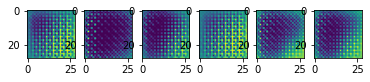

In [313]:
gan.fit(dataset, epochs=EPOCHS, callbacks=[cbk], batch_size=64)